In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from qutip import *
from scipy import *
from h5py import File

In [10]:

    
def read_h5( iter: int , ham : int, ovFlag = False, level = 0, krylovs = []):
        x =  list(File(f"result.h5")[f"{iter}.w.{ham}.riz.{2-ovFlag}.0.0.0"])
        l = int(np.sqrt(len(x[0])))
        x =  np.reshape(x,(l,l))
        return np.array([[ x[i][j] for i in krylovs ] for j in krylovs])
H = {}
krylovs = range(1,64)
for i,n in enumerate(['boson','dicke','external','ising'] + [f'z-{i+1}' for i in range(8)] +[f'd-{i+1}' for i in range(8)]+['a']):
    print(i,n)
    if n in H:
        H[n] += read_h5(1, i+1,krylovs = krylovs)
    else:
        H[n] =  read_h5(1, i+1,krylovs= krylovs)
o = read_h5( 1, 1, True,krylovs = krylovs)
ea,ev = linalg.eig(o)
##system had dicke at 0.25
H['dicke'] *= 4

'condition number', np.sort(ea)[-1]/np.sort(ea)[0]

0 boson
1 dicke
2 external
3 ising
4 z-1
5 z-2
6 z-3
7 z-4
8 z-5
9 z-6
10 z-7
11 z-8
12 d-1
13 d-2
14 d-3
15 d-4
16 d-5
17 d-6
18 d-7
19 d-8
20 a


('condition number', np.complex128(1.0841243682971626+0j))

In [11]:
##ENGINEER DEGENERACY OF states
h0 =H['boson'] +0.25* H['dicke'] + H['external'] 
linalg.eig(h0,o);

In [12]:
    #HAMILTONIAN



    H0 = Qobj(h0)
    ##INTERACTION
    # TURN ON ISING TERM,
        ##nearest neighbors chat
    H1 = Qobj(H['ising'])

    ##OBSERVABLES
        #observe photon count
        #observe average z of spin block
    Obs = [Qobj(H['boson'])]#Qobj( np.diag(np.sum([np.eye(10)[i] for i in [8,9]],axis=0)))]#,Qobj(H['y']),Qobj(H['z']), Qobj( np.diag(np.eye(16)[15]))]

    #LINDBAD QUANTUM OBSERVATIONS
    #--actions on Hamiltonian--
    Ops = []


    ##start in Ground State
    ea,ev = linalg.eig(h0)
    ev = np.transpose(ev)
    GsA= ev[np.argmin(ea)]
    ea[np.argmin(ea)] = 0
    GsB= ev[np.argmin(ea)]
    Gs = Qobj(GsA  )

np.sort(ea);

In [13]:
tlist  = np.linspace(0.0, 50, 1001)
args = {}
psi0   = Gs

In [14]:
amp = -1
def drive(t,args):
        """
        Just a function to define a driving field
        """
        return amp*((1 if 10 < t and t < 15 else 0 )+(1 if 135 < t and t < 140 else 0 )+(1 if 180 < t and t < 185 else 0 ))#*np.sin(args['w'] * t)#(step(t)+ step(t-10)+step(t-100))*amp#



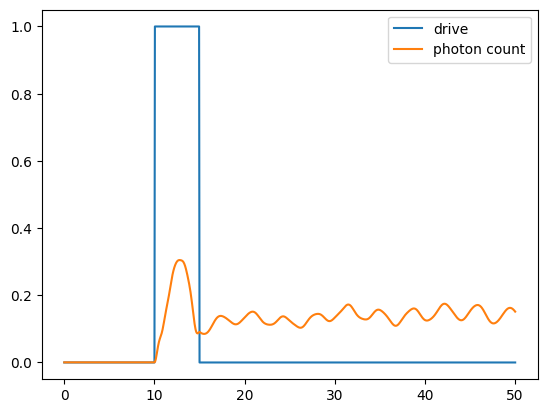

In [15]:
def simulate(tlist,amp,psi0,args):
    MM = len(krylovs)
    H = [H0, [H1, lambda t, args:  drive(t,args)]] 
    
    if False:
        # find the floquet modes for the time-dependent hamiltonian
        f_modes_0,f_energies = floquet_modes(H, T, args)

        # decompose the inital state in the floquet modes
        f_coeff = floquet_state_decomposition(f_modes_0, f_energies, psi0)

        # calculate the wavefunctions using the from the floquet modes
        p_ex = np.zeros(len(tlist))
        for n, t in enumerate(tlist):
            psi_t = floquet_wavefunction_t(f_modes_0, f_energies, f_coeff, t, H, T, args)
            p_ex[n] = expect(Obs, psi_t)

        plt.plot(tlist, p_ex)        
    else:
    # For reference: calculate the same thing with mesolve
        p_ex = mesolve(H, psi0, tlist, Ops, Obs, args).expect
    #p_ex = np.transpose(p_ex)
    return p_ex
plt.plot( tlist,list(map(lambda x : drive(x,args)/amp, tlist)), label = 'drive')
plt.plot(tlist,np.transpose(simulate(tlist,0,Gs,args)[0]), label = 'photon count')
#plt.plot(tlist,np.transpose(simulate(tlist,0,Gs,args)[1]), label = 'average spinor')
plt.legend()

#photon number (not observed or emitted)